# MLP to learn the dynamics of the Lorenz system
In this session, we will use what you learned about feedforward neural network to design a neural network that can learn the dynamics of a chaotic system (derived from atmospheric flow) called the Lorenz system.

The equations of the Lorenz system are given by:
    \begin{equation}
    \frac{dx}{dt} = \sigma (y-x), \hspace{11pt} \frac{dy}{dt} = x(\rho-z) - y, \hspace{11pt}, \frac{dz}{dt}=xy-\beta z
    \end{equation}

Typical values for the parameters are $\sigma=10$ and $\beta = 8/3$.

In [1]:
use_colab = True
if use_colab:
    !git clone -b main https://github.com/adoanTUD/CYPHER_MLSchool.git

    # from google.colab import drive
    # drive.mount('/content/drive')

Cloning into 'CYPHER_MLSchool'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 91 (delta 46), reused 65 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (91/91), 20.65 MiB | 4.31 MiB/s, done.
Resolving deltas: 100% (46/46), done.


# 1 Loading librairies

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf

2024-09-10 15:39:31.711853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 15:39:32.549975: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-10 15:39:32.708716: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-10 15:39:32.708754: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# 2 Load dataset

In [3]:
if use_colab:
    fld = './CYPHER_MLSchool/'
else:
    fld = './'

np_file = np.load( fld + 'Lorenz_data/LorenzSys_Lorenz_data.npz')
X = np_file['X'] # Data
dt = np_file['dt']
t_split = np_file['t_stop_train']
t_skip = np_file['t_skip']
val_ratio = np_file['val_ratio']
Lyap = np_file['Lyap']

# remove the transient from the dataset
i_skip = int(t_skip/dt)
X = X[i_skip:,:]

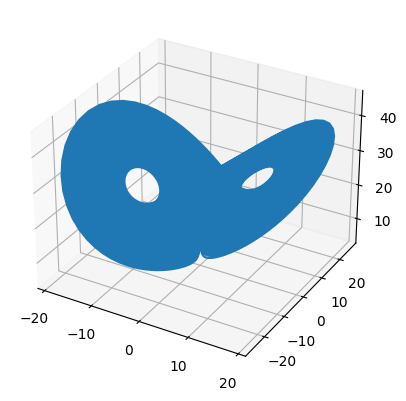

In [4]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot(X[:,0],X[:,1],X[:,2])

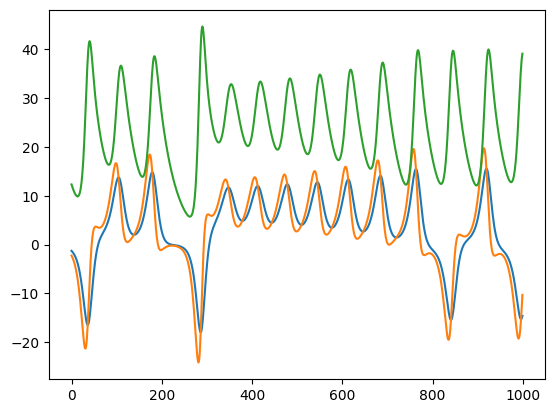

In [5]:
plt.figure()
plt.plot(X[0:1000,0])
plt.plot(X[0:1000,1])
plt.plot(X[0:1000,2])

# 3 Dataset preparation
We now need to define the problem that we try to solve, meaning what is the purpose of our neural network.

Here we will try to develop the neural network so that it can reproduce autonomously the dynamics of the Lorenz system. That means that the input of the neural network will be the $N_{step}$ states in the past, $[\underline{x}(t-N_{step}),...,\underline{x}(t-1)]$, and it has to predict the next state at time $t$, $\underline{x}(t)$.

This allows us to define our training dataset.

In [6]:
# Dataset normalization
Xmean = np.mean(X,0)
Xstd = np.std(X,0)
X = X - np.mean(X,0)
X = X/np.std(X,0)

In [7]:
# we define the input/output split
input_all = X[:-1,:]
output_all = X[1:,:]

# we further split the entire dataset into
# training/validation/test dataset
val_ratio = 0.75
test_ratio = 0.9
idx_val = int(np.round(val_ratio*len(input_all)))
idx_test = int(np.round(test_ratio*len(input_all)))

input_train = input_all[:idx_val,:]
output_train = output_all[:idx_val,:]

input_val = input_all[idx_val:idx_test,:]
output_val = output_all[idx_val:idx_test,:]

input_test = input_all[idx_test:,:]
output_test = output_all[idx_test:,:]

We now need to further reorganize the dataset so that for an input composed of $N_{step}$ timesteps, corresponds the output at time $t$.

In [8]:
Nstep = 10

#reshape the data
inn = []
for i in range(input_train.shape[0]-Nstep):
    inn.append(input_train[i:i+Nstep,:])
input_train = np.array(inn)

input_train = input_train.reshape((input_train.shape[0],Nstep*3))
output_train = output_train[Nstep-1:-1,:]

inn = []
for i in range(input_val.shape[0]-Nstep):
    inn.append(input_val[i:i+Nstep,:])
input_val = np.array(inn)
input_val = input_val.reshape(input_val.shape[0],Nstep*3)
output_val = output_val[Nstep-1:-1,:]

In [9]:
print(output_train.shape)
print(input_train.shape)

(84365, 3)
(84365, 30)


# 4. Definition of our neural network
We now define our neural network

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(30,)))
model.add(tf.keras.layers.Dense(20,activation='relu'))
model.add(tf.keras.layers.Dense(20,activation='relu'))
model.add(tf.keras.layers.Dense(3,activation='linear'))

model.compile(optimizer='adam',loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                620       
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 3)                 63        
                                                                 
Total params: 1,103


2024-09-10 15:39:38.235436: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-09-10 15:39:38.235924: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-09-10 15:39:38.235955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (GLaDOS): /proc/driver/nvidia/version does not exist
2024-09-10 15:39:38.237229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Trainable params: 1,103
Non-trainable params: 0
_________________________________________________________________


# 5. Training of the neural network


In [11]:
checkpoint_filepath = fld + './checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


In [12]:
nb_epochs = 10

history = model.fit(input_train, output_train, validation_data=(input_val, output_val),
                    epochs=nb_epochs, verbose=1, callbacks=[model_checkpoint_callback,early_stop_callback])

model.load_weights(checkpoint_filepath)

Epoch 1/10
2637/2637 [==============================] - 5s 2ms/step - loss: 0.0149 - val_loss: 3.4994e-04
Epoch 2/10
2637/2637 [==============================] - 9s 4ms/step - loss: 2.5294e-04 - val_loss: 1.6726e-04
Epoch 3/10
2637/2637 [==============================] - 9s 3ms/step - loss: 1.6046e-04 - val_loss: 2.2185e-04
Epoch 4/10
2637/2637 [==============================] - 7s 3ms/step - loss: 1.1626e-04 - val_loss: 9.1497e-05
Epoch 5/10
2637/2637 [==============================] - 9s 3ms/step - loss: 8.9792e-05 - val_loss: 5.4229e-05
Epoch 6/10
2637/2637 [==============================] - 7s 3ms/step - loss: 7.8515e-05 - val_loss: 6.0634e-05
Epoch 7/10
2637/2637 [==============================] - 9s 3ms/step - loss: 6.8991e-05 - val_loss: 5.6363e-05
Epoch 8/10
2637/2637 [==============================] - 8s 3ms/step - loss: 6.2410e-05 - val_loss: 4.7345e-05
Epoch 9/10
2637/2637 [==============================] - 7s 3ms/step - loss: 5.5856e-05 - val_loss: 5.5888e-05
Epoch 10/10
26

# 6. Visualization of the prediction from the neural network


In [13]:
x_ref = X[idx_test:,:]
print(x_ref.shape)
x_ref = x_ref[:1000,:]

(11251, 3)


In [14]:
# We look at the natural response of the neural network
Y = []
y_last = x_ref[0:Nstep, :].reshape((1, Nstep*3))
print('start natural response')
for i in range(x_ref.shape[0] - Nstep):
    Y.append(np.array(model.predict(y_last, verbose=0)))
    y_last = np.append(y_last, Y[i].reshape(1, 3), axis=1)
    y_last = y_last[:,3:]
    if (i%50==0):
        print('%d prediction done' % (i + 1))

start natural response
1 prediction done
51 prediction done
101 prediction done
151 prediction done
201 prediction done
251 prediction done
301 prediction done
351 prediction done
401 prediction done
451 prediction done
501 prediction done
551 prediction done
601 prediction done
651 prediction done
701 prediction done
751 prediction done
801 prediction done
851 prediction done
901 prediction done
951 prediction done


In [15]:
Y = np.array(Y)[:,0,:]
Y = np.vstack((x_ref[:Nstep, :], Y))

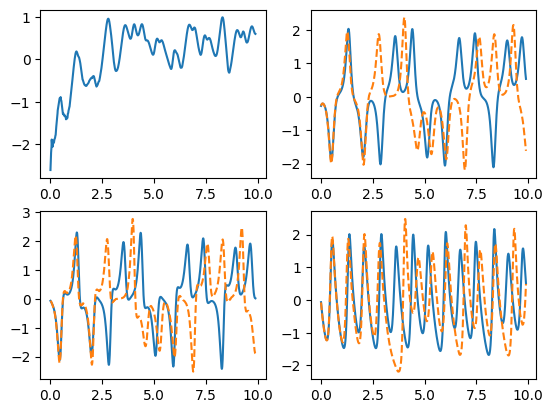

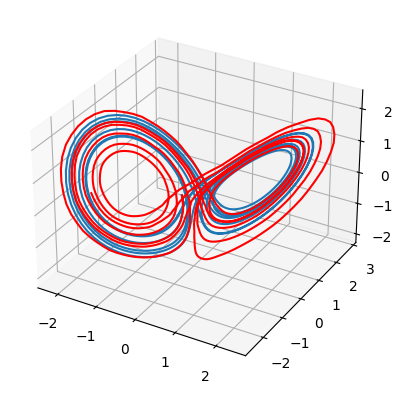

In [16]:
# calculate Error
err = np.log(np.linalg.norm(Y[Nstep:, :] - x_ref[Nstep:, :], axis=1)) / np.sqrt(
    np.average(np.square(np.linalg.norm(x_ref[Nstep:, :], axis=1))))

tlin = np.arange(len(err))*dt
%matplotlib inline
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(tlin,err)

ax2 = fig.add_subplot(222)
ax2.plot(tlin,x_ref[Nstep:, 0])
ax2.plot(tlin,Y[Nstep:, 0], '--')

ax3 = fig.add_subplot(223)
ax3.plot(tlin,x_ref[Nstep:, 1])
ax3.plot(tlin,Y[Nstep:, 1], '--')

ax4 = fig.add_subplot(224)
ax4.plot(tlin,x_ref[Nstep:, 2])
ax4.plot(tlin,Y[Nstep:, 2], '--')

fig2 = plt.figure()
ax3d = fig2.add_subplot(111,projection='3d')
ax3d.plot(x_ref[Nstep:,0],x_ref[Nstep:,1],x_ref[Nstep:,2])
ax3d.plot(Y[Nstep:,0],Y[Nstep:,1],Y[Nstep:,2],'r')


20
10


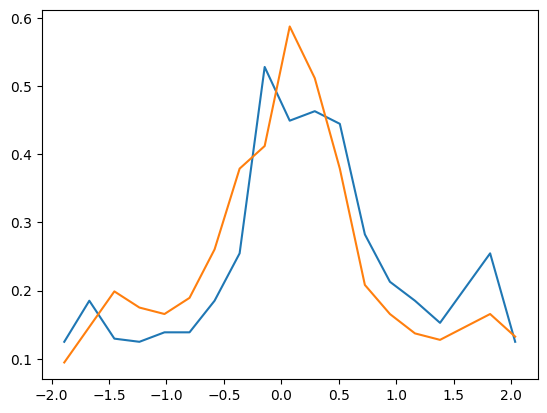

In [21]:
xmin = np.min(x_ref[Nstep:,0])
xmax = np.max(x_ref[Nstep:,0])
xrange = np.linspace(xmin,xmax,20)
hist_ref, bin_edges = np.histogram(x_ref[Nstep:,0], xrange,density=True)
hist_NN, bin_edges = np.histogram(Y[Nstep:,0], xrange,density=True)

%matplotlib inline
plt.plot(xrange[1:],hist_ref)
plt.plot(xrange[1:],hist_NN)